# Strategy 1: Borrowing interest rate based strategy

_Feedback from previous notebook_

Not enough trades, let's look into intra-day

In [30]:
!pip install tqdm

  Using cached tqdm-4.66.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.66.1-py3-none-any.whl (78 kB)


In [77]:
import pandas as pd
import seaborn as sns
from dataclasses import dataclass
from typing import List
import numpy as np
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm
import matplotlib.ticker as mtick
%matplotlib inline

In [2]:
df_combined = pd.read_csv("df_combined_hourly.csv")

In [3]:
df_combined = df_combined.set_index("Date")

In [4]:
df_combined = df_combined[df_combined.index >= "2023-03-01"]

In [5]:
df_combined.head(10)

USDT       BTC  USDT_pct_change  BTC_pct_change  \
Date                                                                       
2023-03-01 00:00:00  0.000256  0.000110              NaN             NaN   
2023-03-01 01:00:00  0.000256  0.000110         0.000000        0.000000   
2023-03-01 02:00:00  0.000256  0.000110         0.000000        0.000000   
2023-03-01 03:00:00  0.000256  0.000110         0.000000        0.000000   
2023-03-01 04:00:00  0.000256  0.000110         0.000000        0.000000   
2023-03-01 05:00:00  0.000256  0.000110         0.000000        0.000000   
2023-03-01 06:00:00  0.000164  0.000098        -0.361362       -0.109455   
2023-03-01 07:00:00  0.000164  0.000098         0.000000        0.000000   
2023-03-01 08:00:00  0.000168  0.000098         0.029768        0.000000   
2023-03-01 09:00:00  0.000172  0.000098         0.019885        0.000000   

                         open      high       low     close  close_pct_change  \
Date                                                                            
2023-03-01 00:00:00  23141.57  23219.99  23020.03  23101.00               NaN   
2023-03-01 01:00:00  23101.00  23296.94  23075.14  23245.96          0.006275   
2023-03-01 02:00:00  23245.96  23336.46  23234.20  23331.21          0.003667   
2023-03-01 03:00:00  23332.57  23498.00  23305.97  23441.14          0.004712   
2023-03-01 04:00:00  23440.37  23847.00  23425.44  23794.48          0.015073   
2023-03-01 05:00:00  23794.48  23821.56  23631.97  23694.17         -0.004216   
2023-03-01 06:00:00  23695.14  23803.39  23666.00  23752.75          0.002472   
2023-03-01 07:00:00  23752.75  23762.22  23681.00  23716.06         -0.001545   
2023-03-01 08:00:00  23716.06  24000.00  23681.81  23867.78          0.006397   
2023-03-01 09:00:00  23869.01  23907.68  23725.07  23756.14         -0.004677   

                     close_pct_change_sign  
Date                                        
2023-03-01 00:00:00                    NaN  
2023-03-01 01:00:00                    1.0  
2023-03-01 02:00:00                    1.0  
2023-03-01 03:00:00                    1.0  
2023-03-01 04:00:00                    1.0  
2023-03-01 05:00:00                   -1.0  
2023-03-01 06:00:00                    1.0  
2023-03-01 07:00:00                   -1.0  
2023-03-01 08:00:00                    1.0  
2023-03-01 09:00:00                   -1.0

In [6]:
def generate_signal(interest_rate_currency: str, rolling_window: int, rate_change_threshold: float):
    _df = df_combined.copy()
    _df["rate_change_ma"] = _df[f"{interest_rate_currency}_pct_change"].dropna().rolling(rolling_window).mean()
    return (_df["rate_change_ma"] > rate_change_threshold).rename("signal")

In [168]:
@dataclass
class Trade:
    date: str
    btc_close_price: float
    trade_type: bool # True for enter, False for exit
    amount: float
    unit: float

    def __repr__(self):
        str_type = "Enter" if self.trade_type else "Exit"
        lines = (f"=== {str_type} Position ===",
                 f"Date: {self.date}",
                 f"BTC Close Price: {self.btc_close_price}",
                 f"{str_type} Amount: $ {self.amount:,.2f}",
                 f"{str_type} Unit: ₿ {self.unit:,.8f}",
                 "=== End ===")
        return "\n".join(lines)

@dataclass
class StrategySummary:
    start_date: str
    end_date: str
    starting_capital: float
    trades: List[Trade]
    total_pnl: float
    total_pnl_pct: float
    sharpe_ratio: float
    days_in_market: int
    days_in_market_pct: float
    portfolio_value_timeline: pd.Series
    max_drawdown_pct: float
    max_drawdown_period: float
    drawdown_period_timeline: pd.Series
    watermark_timeline: pd.Series

    def __repr__(self):
        lines = ("=== Strategy End ===",
                 f"Date Range: {self.start_date} till {self.end_date}",
                 f"No. of Trades: {len(self.trades)}",
                 f"Total PnL: {self.total_pnl:,.2f} ({self.total_pnl_pct:.2%})",
                 f"Sharpe Ratio: {self.sharpe_ratio:.2f}",
                 f"Days in Market: {self.days_in_market:,g} ({self.days_in_market_pct:.2%})")
        return "\n".join(lines)

    def plot_equity_curve(self):
        fig, ax = plt.subplots(figsize=(25, 5))
        self.portfolio_value_timeline.plot(ax=ax)
        return ax

In [172]:
def run_strategy(starting_capital: int, interest_rate_currency: str, rolling_window: int, rate_change_threshold: float, risk_free_rate: float, verbose: bool = False):
    signal = generate_signal(interest_rate_currency=interest_rate_currency, rolling_window=rolling_window, rate_change_threshold=rate_change_threshold)

    _df = df_combined.copy()
    _df = _df.join(signal).dropna(subset=["signal", "close"])

    if verbose:
        print(f"Date Range: {_df.index.min()} till {_df.index.max()}")
        print(f"No. of Trading Days: {len(_df)}")

    cash = starting_capital
    position = 0

    opening_cash = []
    opening_position = []
    closing_cash = []
    closing_position = []

    trades = []

    for id, row in _df[["signal", "close"]].iterrows():
        opening_cash.append(cash)
        opening_position.append(position)
        if row["signal"] and position == 0:
            amount = cash
            unit = amount / row["close"]
            position += unit
            cash -= amount
            trade = Trade(
                date=id,
                btc_close_price=row["close"],
                trade_type=True,
                amount=amount,
                unit=unit
            )
            if verbose:
                print(trade)
            trades.append(trade)
        elif (not row["signal"]) and position > 0:
            unit = position
            amount = unit * row["close"]
            position -= unit
            cash += amount
            trade = Trade(
                date=id,
                btc_close_price=row["close"],
                trade_type=False,
                amount=amount,
                unit=unit
            )
            if verbose:
                print(trade)
            trades.append(trade)
        closing_cash.append(cash)
        closing_position.append(position)

    
    _df["opening_cash"] = opening_cash
    _df["opening_position"] = opening_position
    _df["closing_cash"] = closing_cash
    _df["closing_position"] = closing_position
    
    _df["closing_value"] = _df["closing_cash"] + _df["closing_position"] * _df["close"]
    _df["return"] = _df["closing_value"].pct_change()
    _df["excess_return"] = _df["return"] - risk_free_rate
    _df["drawdown_pct"] = 1 - _df["closing_value"] / _df["closing_value"].expanding().max()
    _df["drawdown_period"] = _df["drawdown_pct"].groupby((_df["drawdown_pct"] == 0).cumsum()).cumcount()

    perf = StrategySummary(
        start_date=_df.index[0],
        end_date=_df.index[-1],
        starting_capital=starting_capital,
        trades=trades,
        total_pnl=_df["closing_value"].iloc[-1] - starting_capital,
        total_pnl_pct=_df["closing_value"].iloc[-1] / starting_capital - 1,
        sharpe_ratio=(_df['excess_return'].mean() / _df['excess_return'].std()) if len(trades) > 0 else None,
        days_in_market=(_df["closing_position"] > 0).sum(),
        days_in_market_pct=(_df["closing_position"] > 0).mean(),
        portfolio_value_timeline=_df["closing_value"],
        max_drawdown_pct=_df["drawdown_pct"].max(),
        max_drawdown_period=_df["drawdown_period"].max(),
        drawdown_period_timeline=_df["drawdown_period"],
        watermark_timeline=_df["drawdown_pct"]
    )
    return perf

    

<Axes: ylabel='Frequency'>

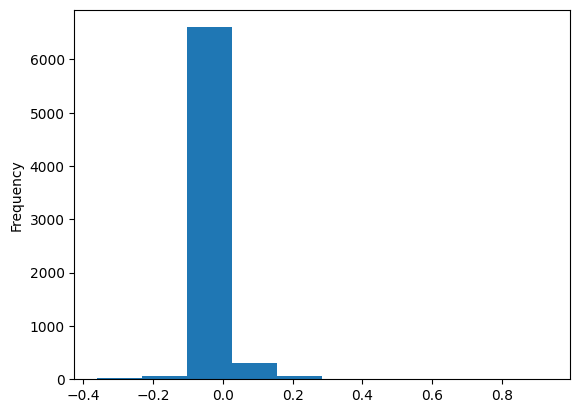

In [38]:
df_combined["USDT_pct_change"].plot.hist()

In [39]:
time_period = 365 * 24 # 1Y to hours
risk_free_rate = .0494 / time_period # 1Y T Bill

In [48]:
windows = list(range(1, 36))
thresholds = np.linspace(0,0.5,11)

df_sr = []
for window in tqdm(windows):
    df_sr.append(
        [
            run_strategy(
                starting_capital=100,
                interest_rate_currency="USDT",
                rolling_window=window,
                rate_change_threshold=threshold,
                risk_free_rate=risk_free_rate
            ).sharpe_ratio
            for threshold in thresholds
        ]
    )
df_sr = pd.DataFrame(df_sr, index=windows, columns=thresholds) * np.sqrt(time_period)

# df_in_market_pct = []
# for window in windows:
#     df_in_market_pct.append(
#         [
#             run_strategy(
#                 starting_capital=100,
#                 interest_rate_currency="USDT",
#                 rolling_window=window,
#                 rate_change_threshold=threshold,
#                 daily_risk_free_rate=daily_risk_free_rate
#             ).days_in_market_pct
#             for threshold in thresholds
#         ]
#     )
# df_in_market_pct = pd.DataFrame(df_in_market_pct, index=windows, columns=thresholds)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:35<00:00,  1.02s/it]


Text(283.22222222222223, 0.5, 'Rolling Window (Hour)')

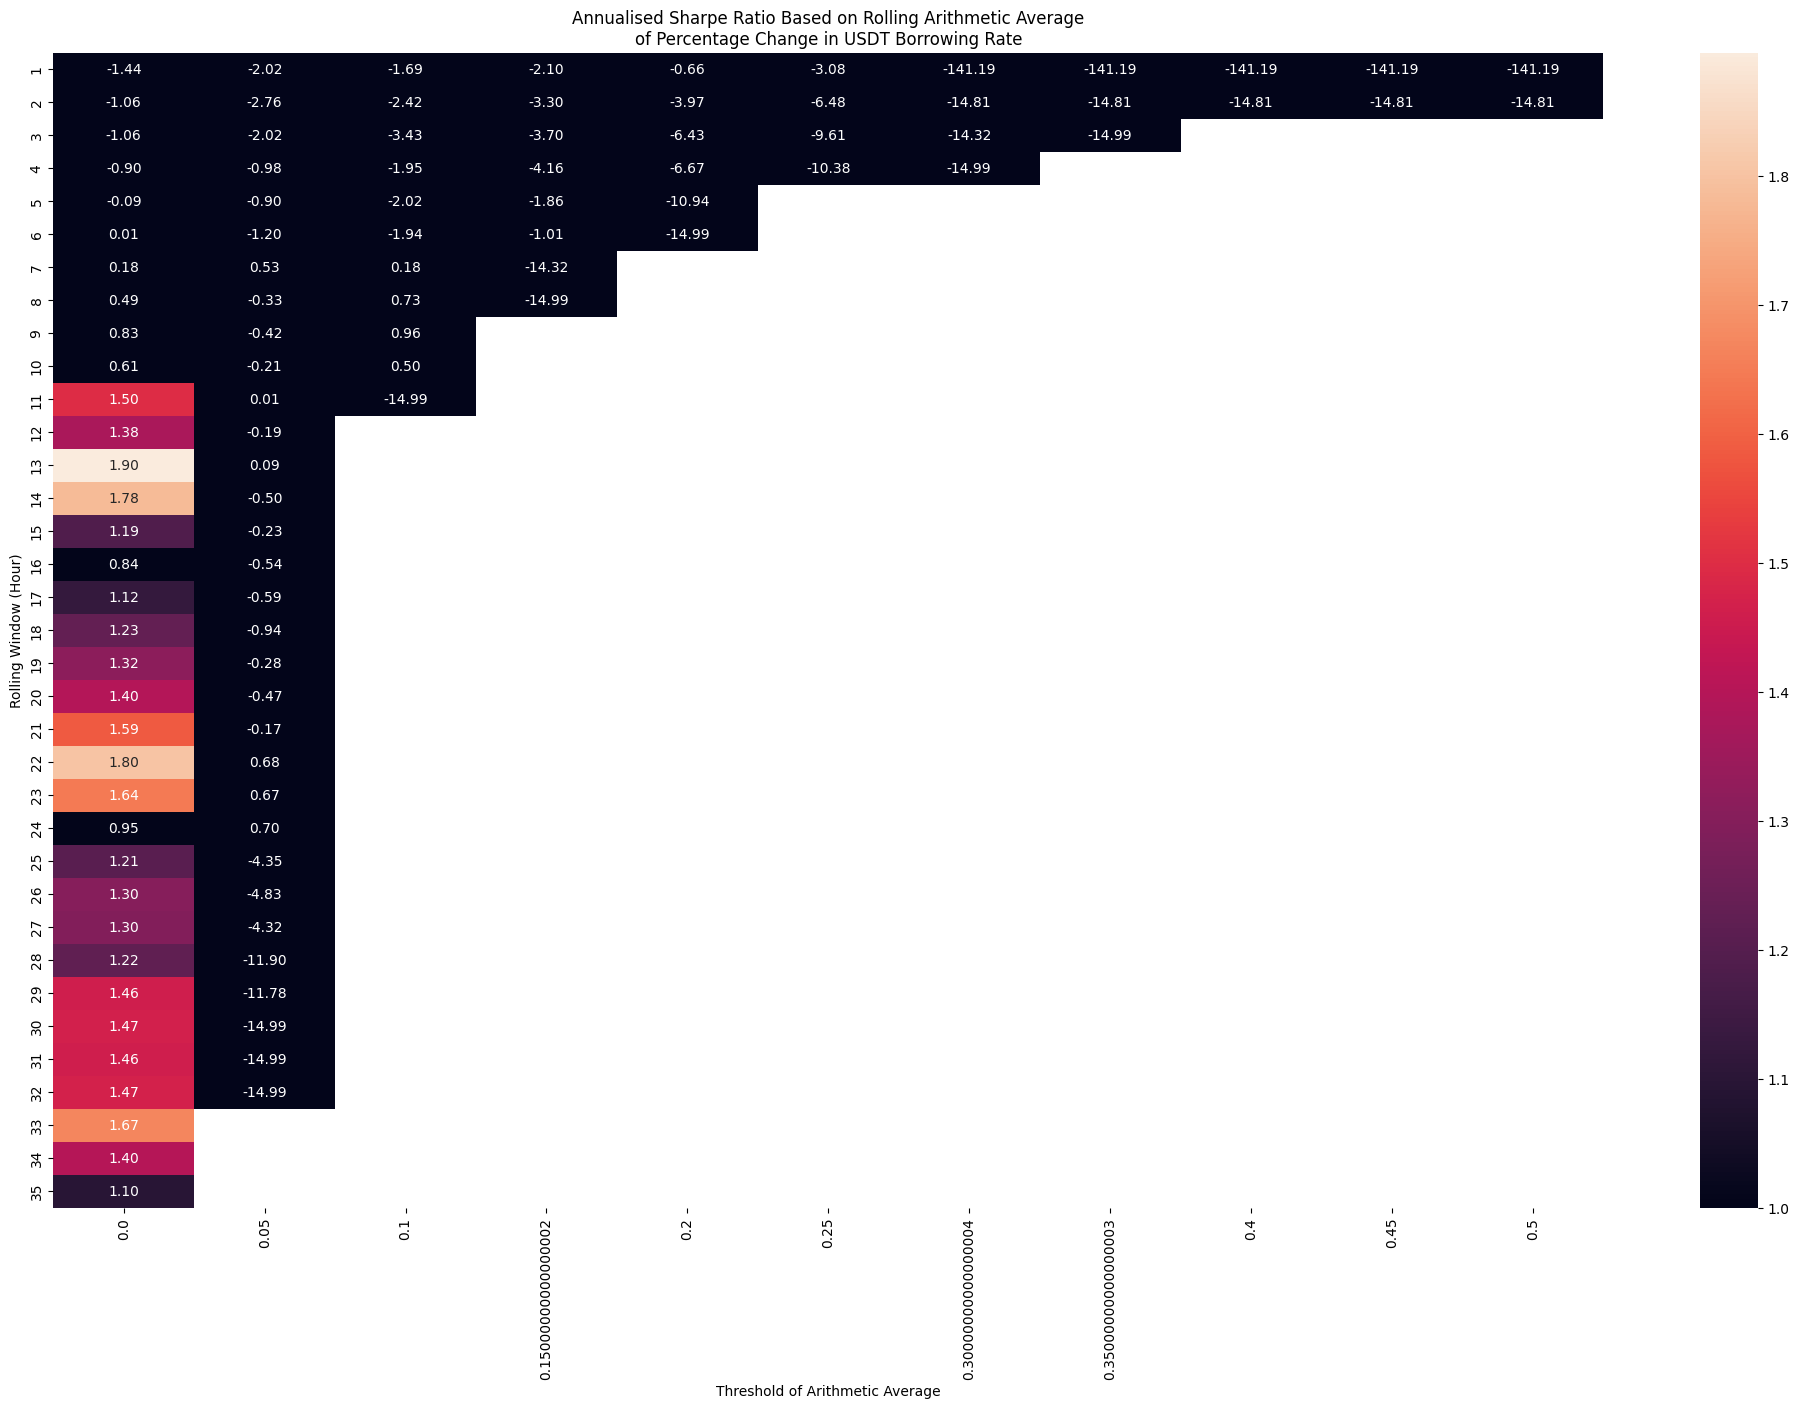

In [51]:
fig, ax = plt.subplots(figsize=(25,15))
ax = sns.heatmap(df_sr.astype(float), annot=True, fmt=".2f", ax=ax, vmin=1, vmax=df_sr.max().max(), robust=True)
ax.set_title("Annualised Sharpe Ratio Based on Rolling Arithmetic Average\nof Percentage Change in USDT Borrowing Rate")
ax.set_xlabel("Threshold of Arithmetic Average")
ax.set_ylabel("Rolling Window (Hour)")

In [86]:
windows = list(range(0, 721))
thresholds = np.linspace(0,0.005,21)

df_sr = []
for window in tqdm(windows):
    df_sr.append(
        [
            run_strategy(
                starting_capital=100,
                interest_rate_currency="USDT",
                rolling_window=window,
                rate_change_threshold=threshold,
                risk_free_rate=risk_free_rate
            ).sharpe_ratio
            for threshold in thresholds
        ]
    )
df_sr = pd.DataFrame(df_sr, index=windows, columns=thresholds) * np.sqrt(time_period)

# df_in_market_pct = []
# for window in windows:
#     df_in_market_pct.append(
#         [
#             run_strategy(
#                 starting_capital=100,
#                 interest_rate_currency="USDT",
#                 rolling_window=window,
#                 rate_change_threshold=threshold,
#                 daily_risk_free_rate=daily_risk_free_rate
#             ).days_in_market_pct
#             for threshold in thresholds
#         ]
#     )
# df_in_market_pct = pd.DataFrame(df_in_market_pct, index=windows, columns=thresholds)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 721/721 [22:47<00:00,  1.90s/it]


Text(283.22222222222223, 0.5, 'Rolling Window (Hour)')

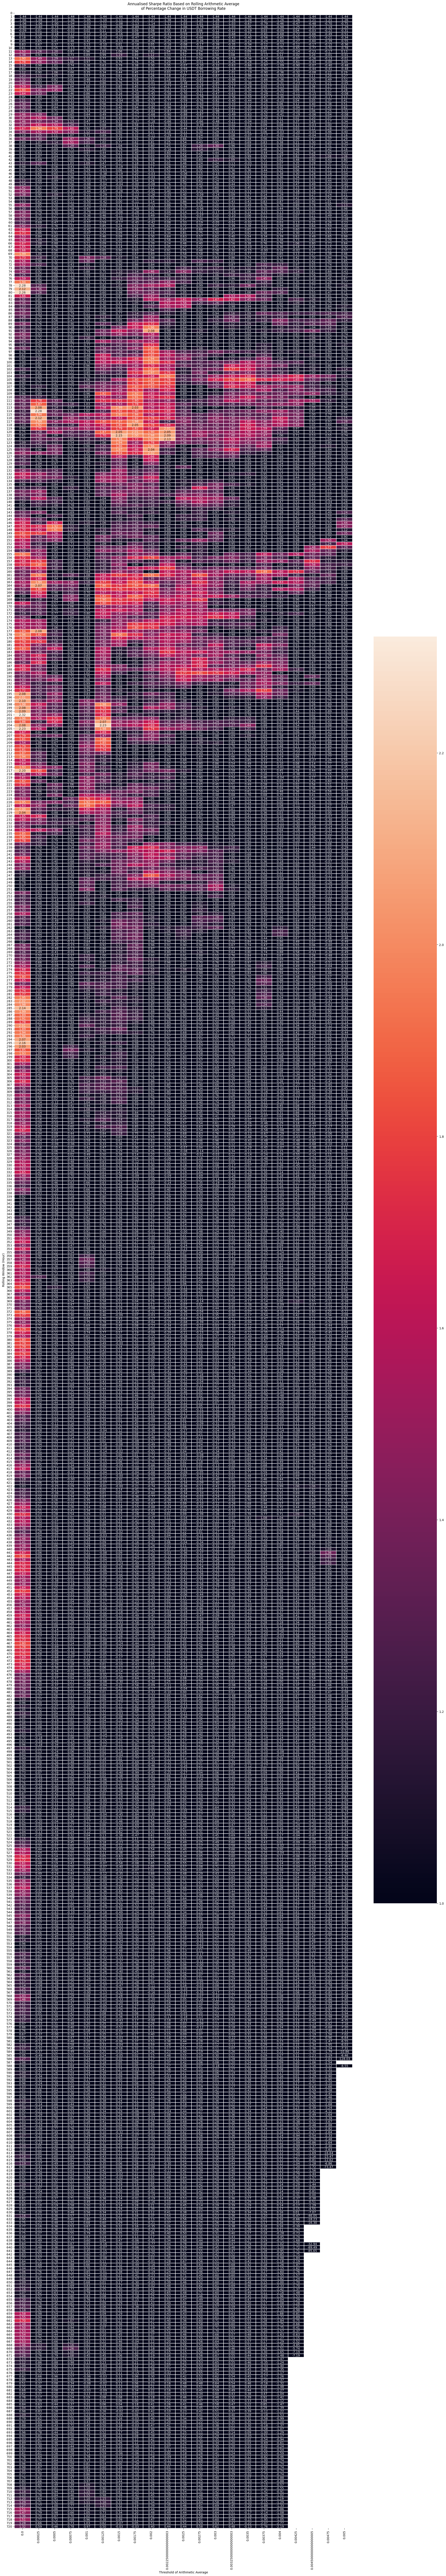

In [90]:
fig, ax = plt.subplots(figsize=(25,150))
ax = sns.heatmap(df_sr.astype(float), annot=True, fmt=".2f", ax=ax, vmin=1, vmax=df_sr.max().max(), robust=True, linewidth=.05)
ax.set_title("Annualised Sharpe Ratio Based on Rolling Arithmetic Average\nof Percentage Change in USDT Borrowing Rate")
ax.set_xlabel("Threshold of Arithmetic Average")
ax.set_ylabel("Rolling Window (Hour)")
# ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

In [173]:
parameters = dict(
    starting_capital=100,
    interest_rate_currency="USDT",
    rolling_window=120,
    rate_change_threshold=0.0015,
    risk_free_rate=risk_free_rate
)
result = run_strategy(
    **parameters
)

Text(0.5, 1.0, "Equity Curve\nStart Date: 2023-03-01 00:00:00\nEnd Date: 2023-12-20 08:00:00\nNo. Trade: 103\nPnL: 41.41%\nAnnualised Sharpe Ratio: 2.05\nMax Drawdown: 9.66%\nMax Drawdown Period: 3,956\nFull Parameters:{'starting_capital': 100, 'interest_rate_currency': 'USDT', 'rolling_window': 120, 'rate_change_threshold': 0.0015, 'risk_free_rate': 5.639269406392694e-06}")

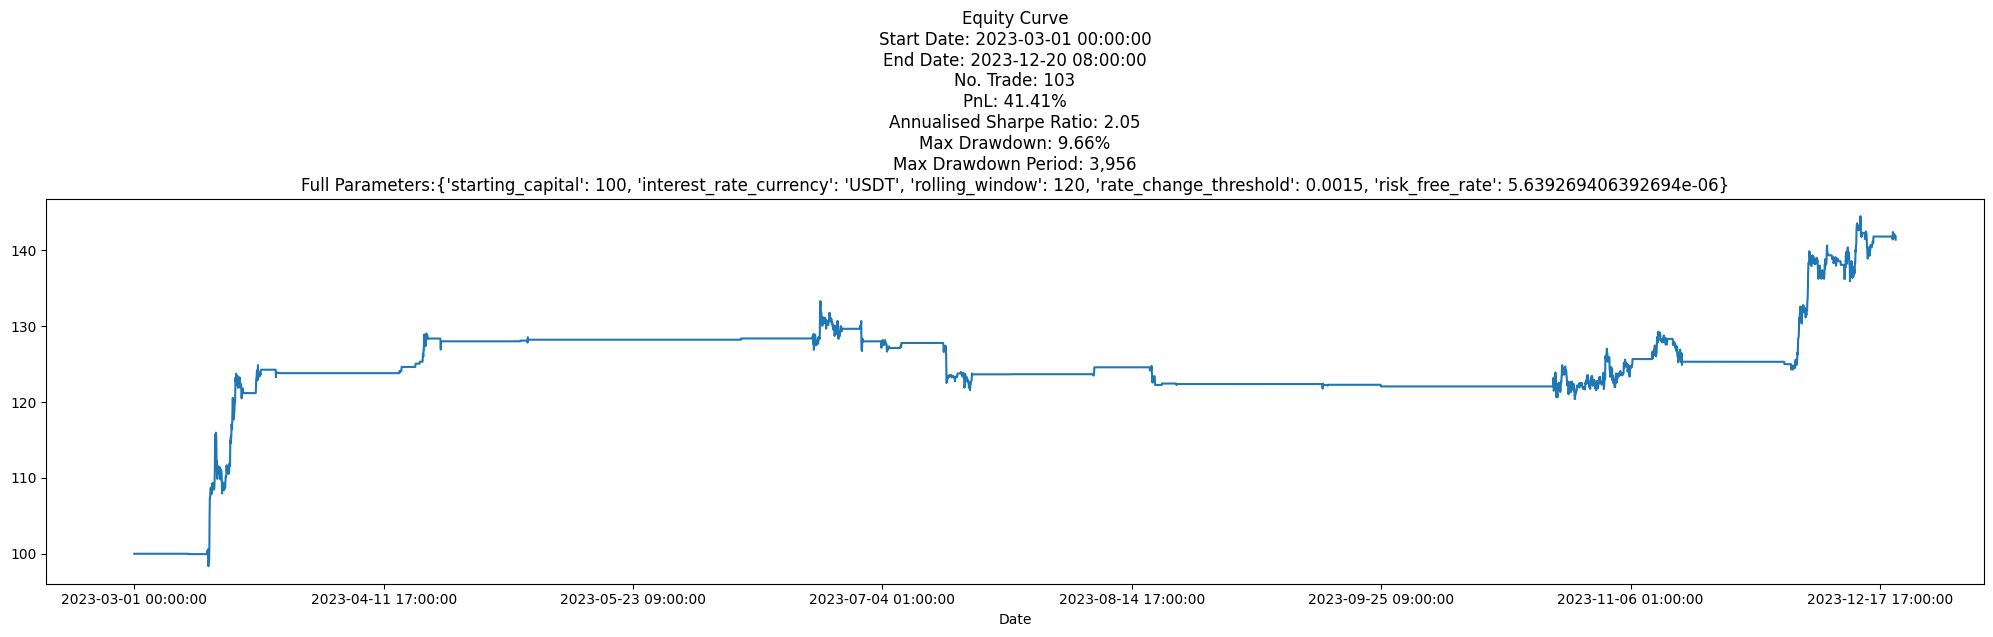

In [176]:
ax = result.plot_equity_curve()
ax.set_title(f"""Equity Curve
Start Date: {result.start_date}
End Date: {result.end_date}
No. Trade: {len(result.trades):,g}
PnL: {result.total_pnl_pct:.2%}
Annualised Sharpe Ratio: {result.sharpe_ratio * np.sqrt(time_period):.2f}
Max Drawdown: {result.max_drawdown_pct:.2%}
Max Drawdown Period: {result.max_drawdown_period:,g}
Full Parameters:{parameters}""")

In [180]:
parameters = dict(
    starting_capital=100,
    interest_rate_currency="USDT",
    rolling_window=79,
    rate_change_threshold=0,
    risk_free_rate=risk_free_rate
)
result = run_strategy(
    **parameters
)

Text(0.5, 1.0, "Equity Curve\nStart Date: 2023-03-01 00:00:00\nEnd Date: 2023-12-20 08:00:00\nNo. Trade: 299\nPnL: 77.02%\nAnnualised Sharpe Ratio: 2.12\nMax Drawdown: 19.57%\nMax Drawdown Period: 2,679\nFull Parameters:{'starting_capital': 100, 'interest_rate_currency': 'USDT', 'rolling_window': 79, 'rate_change_threshold': 0, 'risk_free_rate': 5.639269406392694e-06}")

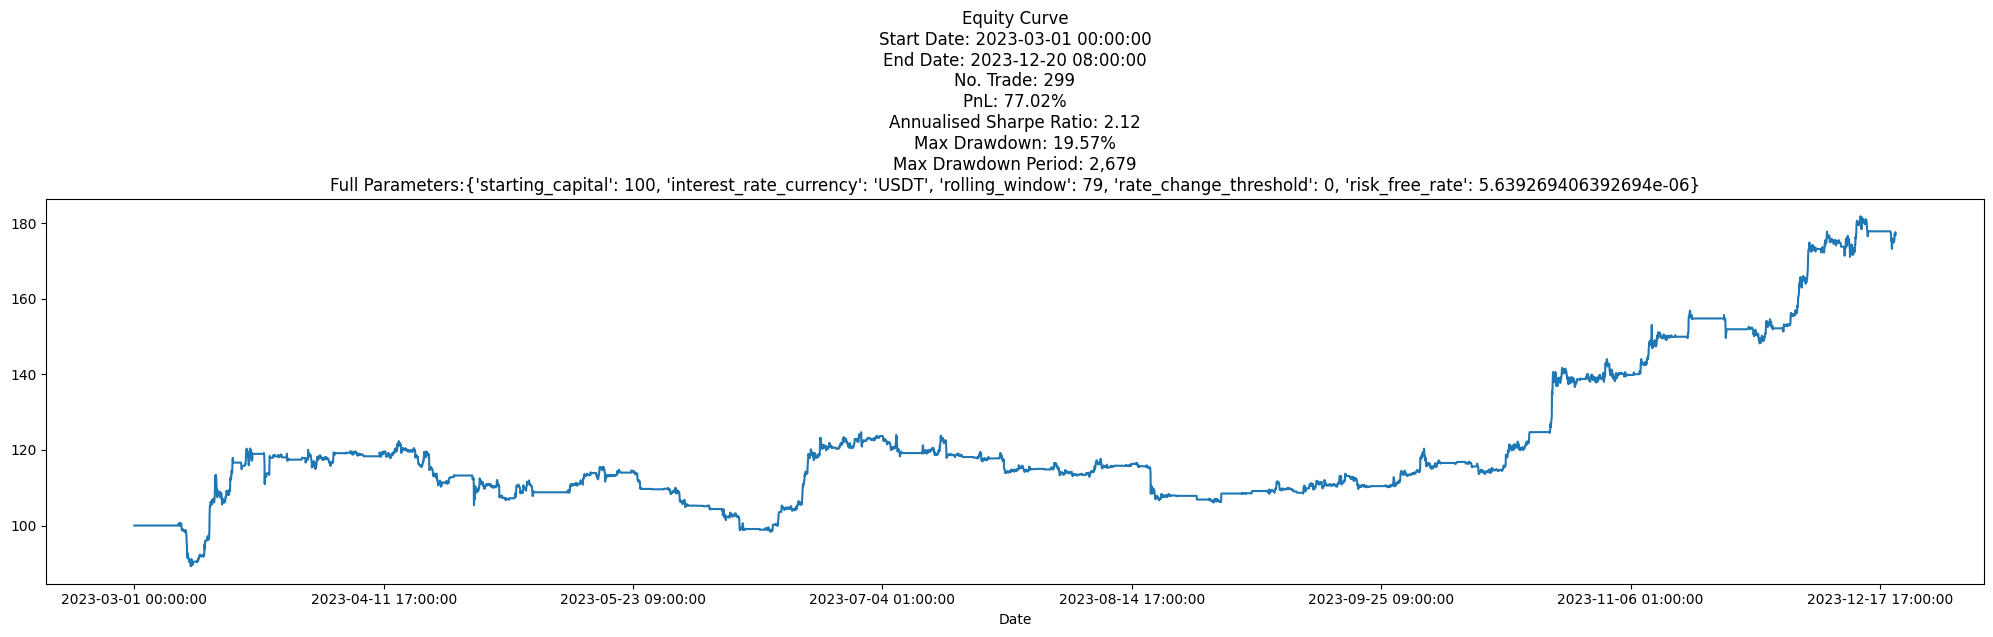

In [181]:
ax = result.plot_equity_curve()
ax.set_title(f"""Equity Curve
Start Date: {result.start_date}
End Date: {result.end_date}
No. Trade: {len(result.trades):,g}
PnL: {result.total_pnl_pct:.2%}
Annualised Sharpe Ratio: {result.sharpe_ratio * np.sqrt(time_period):.2f}
Max Drawdown: {result.max_drawdown_pct:.2%}
Max Drawdown Period: {result.max_drawdown_period:,g}
Full Parameters:{parameters}""")

In [182]:
parameters = dict(
    starting_capital=100,
    interest_rate_currency="USDT",
    rolling_window=115,
    rate_change_threshold=.00025,
    risk_free_rate=risk_free_rate
)
result = run_strategy(
    **parameters
)

Text(0.5, 1.0, "Equity Curve\nStart Date: 2023-03-01 00:00:00\nEnd Date: 2023-12-20 08:00:00\nNo. Trade: 283\nPnL: 57.59%\nAnnualised Sharpe Ratio: 1.94\nMax Drawdown: 17.90%\nMax Drawdown Period: 2,841\nFull Parameters:{'starting_capital': 100, 'interest_rate_currency': 'USDT', 'rolling_window': 115, 'rate_change_threshold': 0.00025, 'risk_free_rate': 5.639269406392694e-06}")

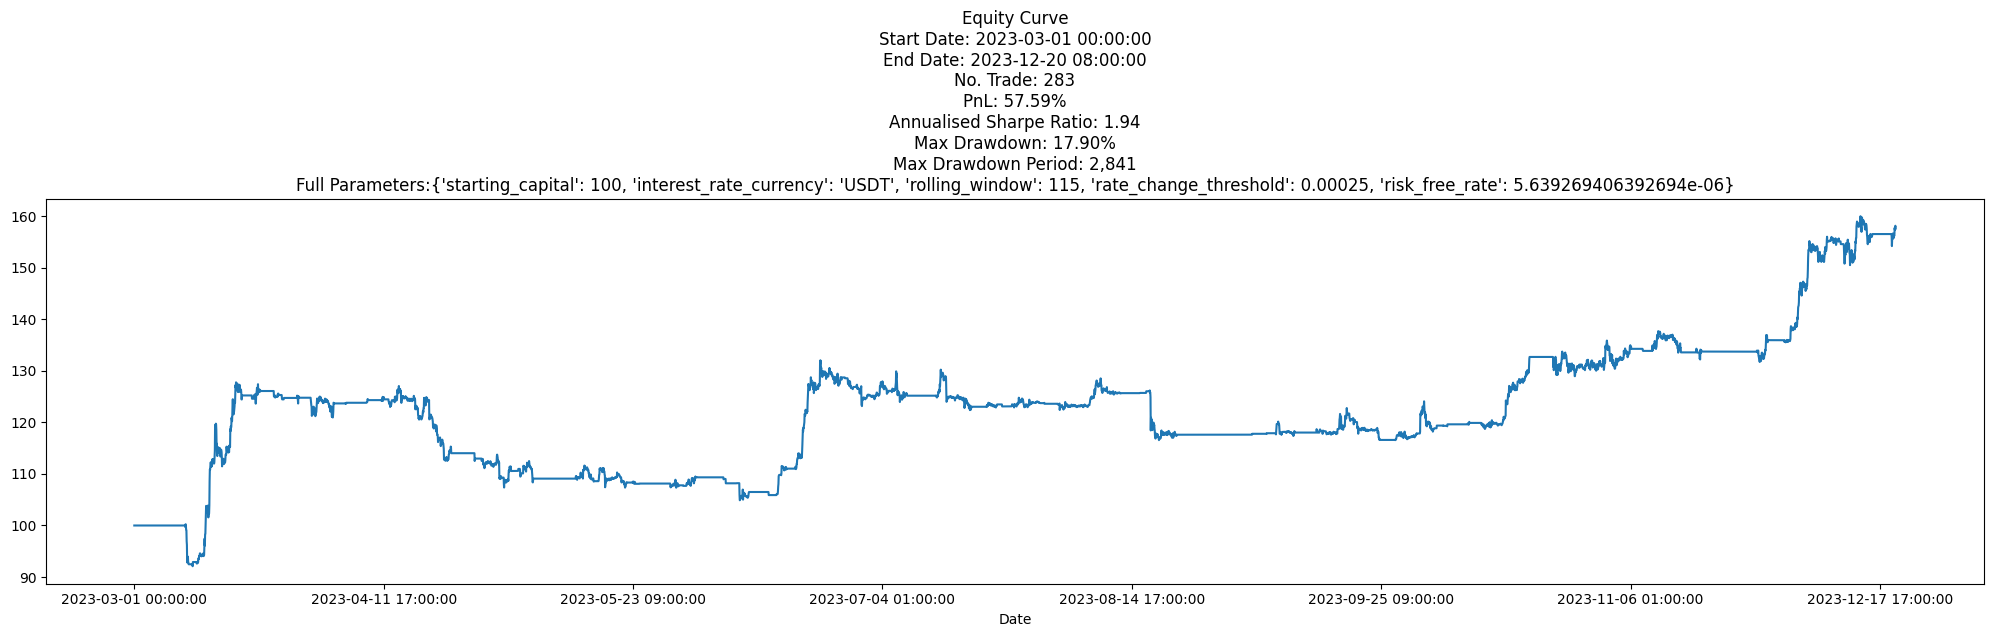

In [183]:
ax = result.plot_equity_curve()
ax.set_title(f"""Equity Curve
Start Date: {result.start_date}
End Date: {result.end_date}
No. Trade: {len(result.trades):,g}
PnL: {result.total_pnl_pct:.2%}
Annualised Sharpe Ratio: {result.sharpe_ratio * np.sqrt(time_period):.2f}
Max Drawdown: {result.max_drawdown_pct:.2%}
Max Drawdown Period: {result.max_drawdown_period:,g}
Full Parameters:{parameters}""")

In [184]:
parameters = dict(
    starting_capital=100,
    interest_rate_currency="USDT",
    rolling_window=200,
    rate_change_threshold=0,
    risk_free_rate=risk_free_rate
)
result = run_strategy(
    **parameters
)

Text(0.5, 1.0, "Equity Curve\nStart Date: 2023-03-01 00:00:00\nEnd Date: 2023-12-20 08:00:00\nNo. Trade: 213\nPnL: 73.13%\nAnnualised Sharpe Ratio: 2.09\nMax Drawdown: 19.06%\nMax Drawdown Period: 5,012\nFull Parameters:{'starting_capital': 100, 'interest_rate_currency': 'USDT', 'rolling_window': 200, 'rate_change_threshold': 0, 'risk_free_rate': 5.639269406392694e-06}")

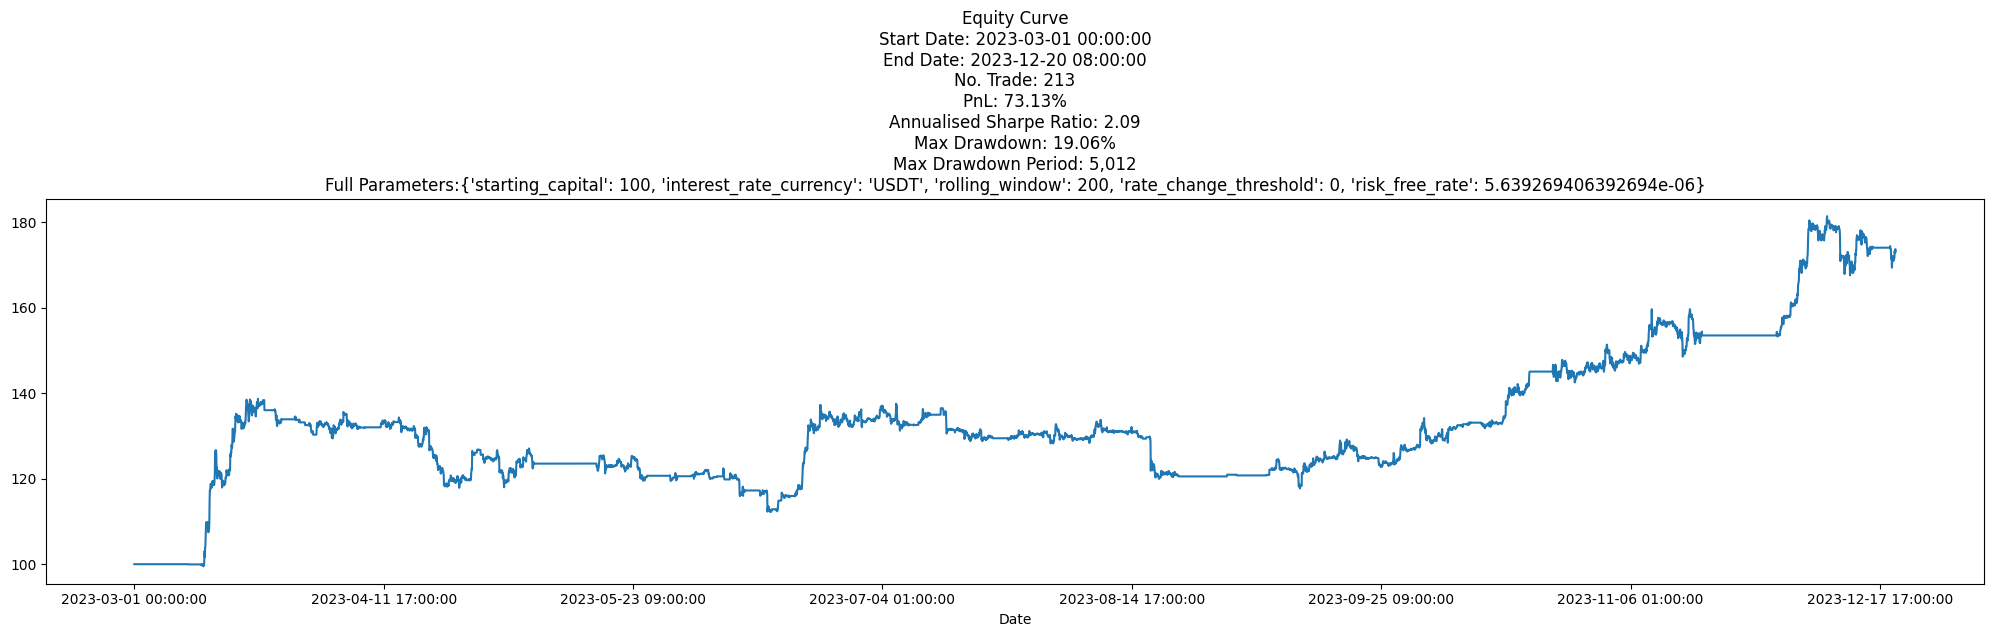

In [185]:
ax = result.plot_equity_curve()
ax.set_title(f"""Equity Curve
Start Date: {result.start_date}
End Date: {result.end_date}
No. Trade: {len(result.trades):,g}
PnL: {result.total_pnl_pct:.2%}
Annualised Sharpe Ratio: {result.sharpe_ratio * np.sqrt(time_period):.2f}
Max Drawdown: {result.max_drawdown_pct:.2%}
Max Drawdown Period: {result.max_drawdown_period:,g}
Full Parameters:{parameters}""")

In [190]:
# Get all combinations over SR 1.9

combinations = []
for threshold in df_sr.columns:
    combinations.extend([(_, threshold) for _ in df_sr.index[df_sr[threshold] > 1.9]])

print(combinations)

[(69, 0.0), (77, 0.0), (78, 0.0), (79, 0.0), (80, 0.0), (155, 0.0), (178, 0.0), (195, 0.0), (196, 0.0), (197, 0.0), (198, 0.0), (199, 0.0), (200, 0.0), (201, 0.0), (202, 0.0), (204, 0.0), (205, 0.0), (213, 0.0), (216, 0.0), (217, 0.0), (226, 0.0), (228, 0.0), (229, 0.0), (282, 0.0), (283, 0.0), (284, 0.0), (285, 0.0), (286, 0.0), (288, 0.0), (290, 0.0), (292, 0.0), (293, 0.0), (294, 0.0), (295, 0.0), (296, 0.0), (298, 0.0), (33, 0.00025), (113, 0.00025), (114, 0.00025), (115, 0.00025), (116, 0.00025), (117, 0.00025), (118, 0.00025), (161, 0.00025), (163, 0.00025), (164, 0.00025), (177, 0.00025), (147, 0.0005), (148, 0.0005), (226, 0.001), (198, 0.00125), (203, 0.00125), (204, 0.00125), (205, 0.00125), (113, 0.0015), (115, 0.0015), (120, 0.0015), (121, 0.0015), (122, 0.0015), (123, 0.0015), (125, 0.0015), (178, 0.0015), (109, 0.00175), (110, 0.00175), (113, 0.00175), (117, 0.00175), (118, 0.00175), (120, 0.00175), (121, 0.00175), (90, 0.002), (91, 0.002), (99, 0.002), (100, 0.002), (103

In [191]:
performance = []
for window, threshold in combinations:
    performance.append(
        run_strategy(
            starting_capital=100,
            interest_rate_currency="USDT",
            rolling_window=window,
            rate_change_threshold=threshold,
            risk_free_rate=risk_free_rate
        )
    )

In [196]:
getattr(performance[0], "sharpe_ratio")

0.021303775961789933

In [205]:
pd.set_option('display.max_rows', 100)
df_performance = pd.DataFrame(
    [
        {
            "pnl_pct": p.total_pnl_pct,
            "sharpe_ratio": p.sharpe_ratio * np.sqrt(time_period),
            "max_drawdown_pct": p.max_drawdown_pct,
            "max_drawdown_period": p.max_drawdown_period,
            "trades": len(p.trades)
        } for p in performance
    ],
    index=combinations
).sort_values(by=["sharpe_ratio"], ascending=False)

In [206]:
df_performance

pnl_pct  sharpe_ratio  max_drawdown_pct  \
(201, 0.0)                    0.844292      2.321268          0.155557   
(114, 0.00025)                0.706558      2.284519          0.152099   
(78, 0.0)                     0.842153      2.280033          0.187218   
(80, 0.0)                     0.833640      2.256491          0.171879   
(204, 0.00125)                0.485440      2.232903          0.092830   
(205, 0.0)                    0.791670      2.226211          0.170518   
(217, 0.0)                    0.794919      2.196309          0.187179   
(295, 0.0)                    0.831135      2.159340          0.176990   
(121, 0.0015)                 0.437837      2.152082          0.092392   
(285, 0.0)                    0.812098      2.136224          0.183149   
(122, 0.0022500000000000003)  0.400525      2.125130          0.105825   
(79, 0.0)                     0.770249      2.120725          0.195655   
(116, 0.00025)                0.640554      2.116724          0.180482   
(197, 0.0)                    0.724154      2.095037          0.224573   
(121, 0.0022500000000000003)  0.393160      2.094661          0.110113   
(200, 0.0)                    0.731323      2.093555          0.190633   
(199, 0.0)                    0.727157      2.083163          0.192470   
(204, 0.0)                    0.730238      2.082730          0.167576   
(177, 0.00025)                0.643872      2.079773          0.170307   
(195, 0.0)                    0.714692      2.078998          0.225168   
(91, 0.002)                   0.412394      2.076632          0.092684   
(113, 0.00025)                0.627946      2.075956          0.155907   
(203, 0.00125)                0.446596      2.072255          0.090666   
(164, 0.00025)                0.639487      2.067226          0.201143   
(294, 0.0)                    0.783513      2.065470          0.180940   
(120, 0.0015)                 0.414114      2.051833          0.096623   
(118, 0.00175)                0.405633      2.050333          0.093716   
(120, 0.0022500000000000003)  0.383017      2.046957          0.111961   
(125, 0.002)                  0.387371      2.040298          0.096989   
(229, 0.0)                    0.736423      2.036525          0.158509   
(296, 0.0)                    0.740322      2.032633          0.180926   
(113, 0.00175)                0.400426      2.026722          0.099165   
(283, 0.0)                    0.755206      2.020020          0.200721   
(126, 0.002)                  0.385538      2.018380          0.112082   
(290, 0.0)                    0.751736      2.010834          0.195700   
(119, 0.0022500000000000003)  0.375583      2.008481          0.101397   
(196, 0.0)                    0.683791      2.007363          0.214781   
(120, 0.00175)                0.398480      2.007227          0.096467   
(121, 0.00175)                0.398508      1.999786          0.110240   
(228, 0.0)                    0.717165      1.997128          0.175723   
(117, 0.00025)                0.586138      1.994389          0.159864   
(69, 0.0)                     0.693251      1.993924          0.198475   
(286, 0.0)                    0.742515      1.991967          0.190352   
(163, 0.00025)                0.608707      1.990343          0.209324   
(113, 0.0015)                 0.404995      1.989041          0.116140   
(284, 0.0)                    0.739945      1.983462          0.202930   
(117, 0.00175)                0.391244      1.982698          0.097141   
(198, 0.0)                    0.674682      1.981193          0.231817   
(121, 0.002)                  0.378522      1.979930          0.127405   
(205, 0.00125)                0.425708      1.979910          0.105338   
(198, 0.00125)                0.426234      1.978248          0.081916   
(103, 0.002)                  0.382754      1.971265          0.074939   
(125, 0.0015)                 0.405885      1.970926          0.094553   
(122, 0.0015)                 0.399

<Axes: xlabel='trades', ylabel='max_drawdown_pct'>

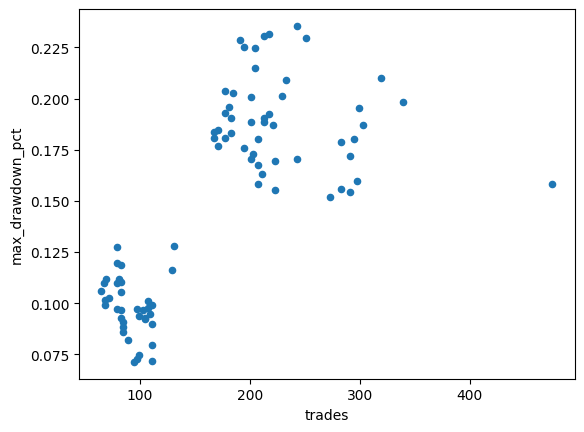

In [207]:
df_performance.plot(x="trades", y="max_drawdown_pct", kind="scatter")

<Axes: xlabel='sharpe_ratio', ylabel='trades'>

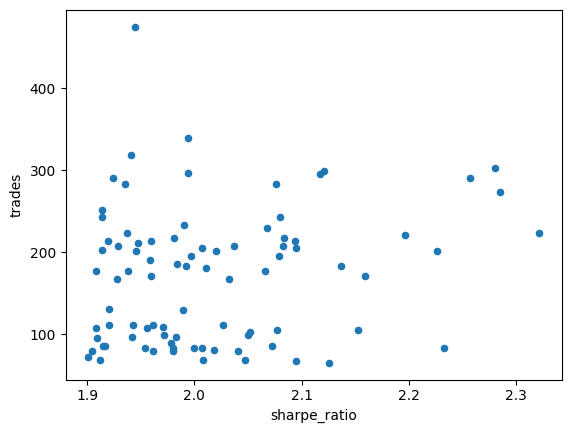

In [209]:
df_performance.plot(x="sharpe_ratio", y="trades", kind="scatter")